### Semi-parametric Psychophysical model tutorial


This tutorial will demonstrate how to fit the semiparametric psychophysical models described in https://arxiv.org/abs/2302.01187. We will step through how to use both the full semiparametric model as well as the multivariate normal-approximate semiparametric model. Each will be evaluated on a 2-dimensional novel descrimination and detection test functions - both variants of the 2D test function discussed in the above work. By stepping through each of these examples, practitioners should learn how to use the model and easily be able to adapt the semiparametric approach to fit to their own psychophysical datasets.

In [3]:
# imports and seeds
import matplotlib.pyplot as plt
import numpy as np
import torch
from aepsych.benchmark.test_functions import novel_detection_testfun, novel_discrimination_testfun
from aepsych.utils import dim_grid, make_scaled_sobol
from scipy.stats import norm
from torch.distributions import Bernoulli, Normal


np.random.seed(1)
torch.manual_seed(1)

Below we import the semip specific packages. Note that we are importing three link functions here, ```FloorGumbelObjective, FloorLogitObjective, FloorProbitObjective```. In this tutorial we will only use the ```FloorLogitObective``` but if you  prefer to use a different link function, feel free to swap this out.

In [4]:
### semip imports
#from aepsych.generators import OptimizeAcqfGenerator, SobolGenerator
from aepsych.likelihoods import BernoulliObjectiveLikelihood
from aepsych.acquisition.objective import (
    FloorGumbelObjective,
    FloorLogitObjective,
    FloorProbitObjective,
)
from aepsych.likelihoods.semi_p import LinearBernoulliLikelihood
from aepsych.models import HadamardSemiPModel, SemiParametricGPModel

#### Test function
Here we will import the novel 2D hairtie detection test function, which provides detection probabilities ranging from 0 to 1 in a two dimensional space. The slope and intercept of the parameterized sigmoidal function smoothly vary along one dimension of the test function.


The lower and upper bound ```lb``` and ```ub``` are needed to specify the boundaries of the function, and should be vectors of length equal to the dimensionality of the dataset you are looking to fit. The function is plotted below.

Text(0.5, 1.0, '2D hairtie detection')

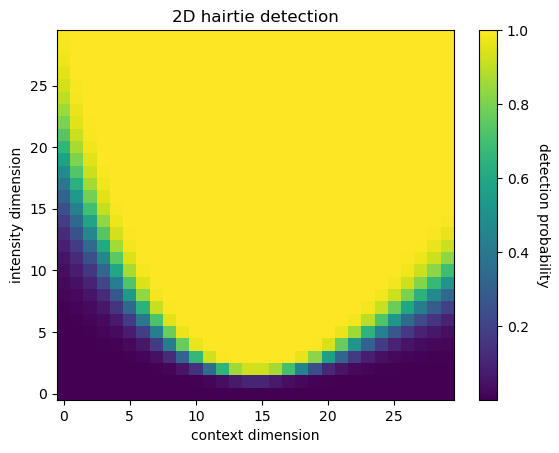

In [5]:
# Hairtie test function
lb = [-1, -1] ##
ub = [1, 1]

xgrid = dim_grid(lower=lb, upper=ub, dim=2)

fgrid = novel_detection_testfun(xgrid)

#plt.subplot
plt.imshow(norm.cdf(fgrid).reshape(30, 30).T, aspect="auto", origin="lower")
cbar = plt.colorbar()
plt.xlabel("context dimension")
plt.ylabel("intensity dimension")

cbar.set_label("detection probability", rotation=270, labelpad=15)
plt.title("2D hairtie detection")

In [6]:
# now generate some data from the Bernoulli distribution defined over a set of training locations

xtrain = make_scaled_sobol(lb=lb, ub=ub, size=30) ##using random sobol sampling here for data generation
ftrain = novel_detection_testfun(xtrain)
ytrain = Bernoulli(torch.Tensor(norm.cdf(ftrain))).sample()


#### Fitting the model
Here we are fitting both the SemiParametric ```SemiParametricGPMOdel``` as well as the MVN-approximate SemiP model ```HadamardSemiPModel``` using the synthetic data generated in the cell above. We show tuning estimation for each model. Note here the argument ```stim_dim``` in the function call. This is needed to specify which dimension in your dataset should be the monotonically increasing (sigmoidal) dimension. This could be, for example, volume in an auditory task, or contrast in a visual task. Identifying which dimension is monotonic is crucial to see good SemiP performance. Here, the second dimension is the monotonic dimensional in our 2D test function.

In [7]:
### fit semip model
semip_model = SemiParametricGPModel(lb=lb, ub=ub, dim=2, stim_dim=1,  likelihood=LinearBernoulliLikelihood(objective=FloorLogitObjective(floor=0)))
approx_model = HadamardSemiPModel(lb=lb, ub=ub, dim=2, stim_dim=1,  likelihood=BernoulliObjectiveLikelihood(objective=FloorLogitObjective(floor=0)))

semip_model.fit(xtrain, ytrain, warmstart_hyperparams=True, warmstart_induc=True)
approx_model.fit(xtrain, ytrain, warmstart_hyperparams=True, warmstart_induc=True)

2023-03-19 21:28:17,732 [INFO   ] Starting fit...
2023-03-19 21:28:18,113 [INFO   ] Fit done, time=0.3802001476287842
2023-03-19 21:28:18,115 [INFO   ] Starting fit...
2023-03-19 21:28:18,359 [INFO   ] Fit done, time=0.24381589889526367


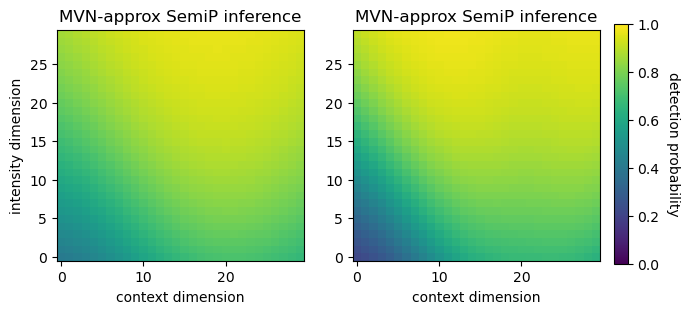

In [13]:
#make predictions at locations on a 2D grid and plot
semiP_pred_mu, _ = semip_model.predict(torch.Tensor(xgrid), probability_space=True)
MVN_pred_mu, _ = approx_model.predict(torch.Tensor(xgrid), probability_space=True)


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].imshow(MVN_pred_mu.reshape(30, 30).T, aspect="auto", origin="lower", vmin=0, vmax = 1)
axs[0].set_title('MVN-approx SemiP inference')
axs[0].set_xlabel("context dimension")
axs[0].set_ylabel("intensity dimension")


im1 = axs[1].imshow(semiP_pred_mu.reshape(30, 30).T, aspect="auto", origin="lower", vmin=0, vmax = 1)
axs[1].set_title('MVN-approx SemiP inference')
axs[1].set_xlabel("context dimension")


cb_ax = fig.add_axes([.92, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)
cbar.set_label("detection probability", rotation=270, labelpad=15)

### Discrimination function evaluation

The semiparametric model can be adapted to different psychophysical task by adjusting the ```floor``` value when you instantiate the model. Below, we show an example using the 2D hairtie discrimination function, which has a minimum value of p = 0.5, corresponding to an inability to discriminate two stimuli. The logic follows from the above example, but here we simply adjust the ```floor``` value and the test function being evaluated

2023-03-19 21:31:05,900 [INFO   ] Starting fit...
2023-03-19 21:31:06,616 [INFO   ] Fit done, time=0.7146298885345459


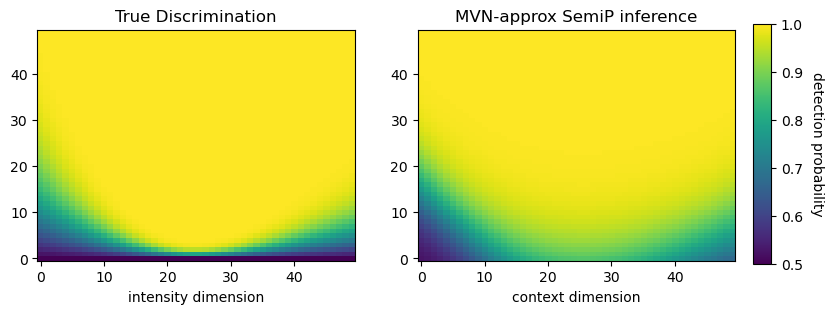

In [16]:

lb = [-1, -1] ##
ub = [1, 1]

xgrid = dim_grid(lower=lb, upper=ub, dim=2, gridsize = 50)

fgrid = novel_discrimination_testfun(xgrid)


# now generate some data from the Bernoulli distribution defined over a set of training locations
xtrain = make_scaled_sobol(lb=lb, ub=ub, size=300) ##using random sobol sampling here for data generation
ftrain = novel_discrimination_testfun(xtrain)
ytrain = Bernoulli(torch.Tensor(norm.cdf(ftrain))).sample()


### fit semip model

## note you can adjust the slope_mean value to bias a steeper rise with intensity. Default value is 2, here we are setting to 6
semip_model = SemiParametricGPModel(lb=lb, ub=ub, dim=2, stim_dim=1, slope_mean = 6, likelihood=LinearBernoulliLikelihood(objective=FloorLogitObjective(floor=0.5)))

semip_model.fit(xtrain, ytrain, warmstart_hyperparams=True, warmstart_induc=True)

#make predictions at locations on a 2D grid and plot
semiP_pred_mu, _ = semip_model.predict(torch.Tensor(xgrid), probability_space=True)


fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].imshow(norm.cdf(fgrid).reshape(50, 50).T, aspect="auto", origin="lower", vmin=0.5, vmax = 1)
axs[0].set_title('True Discrimination')
axs[0].set_xlabel("context dimension")
axs[0].set_xlabel("intensity dimension")

im1 = axs[1].imshow(semiP_pred_mu.reshape(50, 50).T, aspect="auto", origin="lower", vmin=0.5, vmax = 1)
axs[1].set_title('MVN-approx SemiP inference')
axs[1].set_xlabel("context dimension")



cb_ax = fig.add_axes([.92, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)
cbar.set_label("detection probability", rotation=270, labelpad=15)